# California Housing Price Prediction using OLS and Polynomial Regression


In [240]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

california_housing = fetch_california_housing(as_frame=True) 
df = california_housing.frame


In [241]:
df.info()
df.describe().T
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Removing Capped Values

When I explored the California Housing dataset, I noticed that many house values were **capped at 5.0** (meaning $500,000).  
This cap caused a flat line at the top of the scatter plot.  
After filtering out rows where `MedHouseVal >= 5.0`, the relationship between **income** and **house value** looked much clearer.


Removed observations: 27 (0.13%)


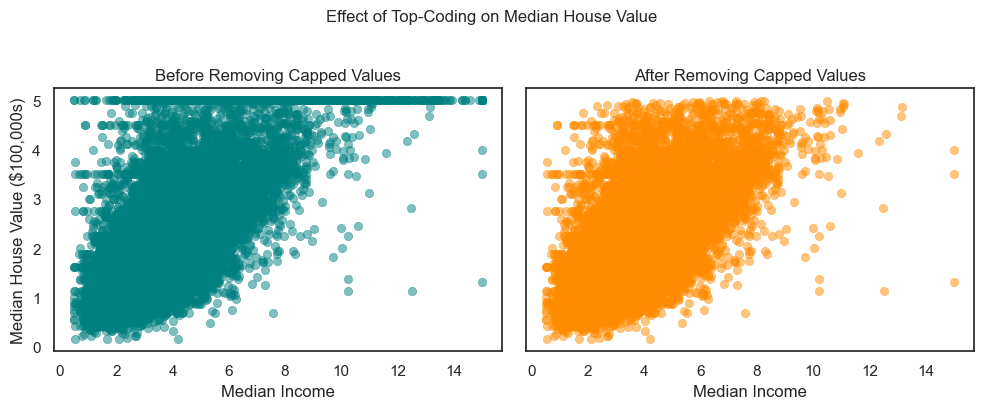

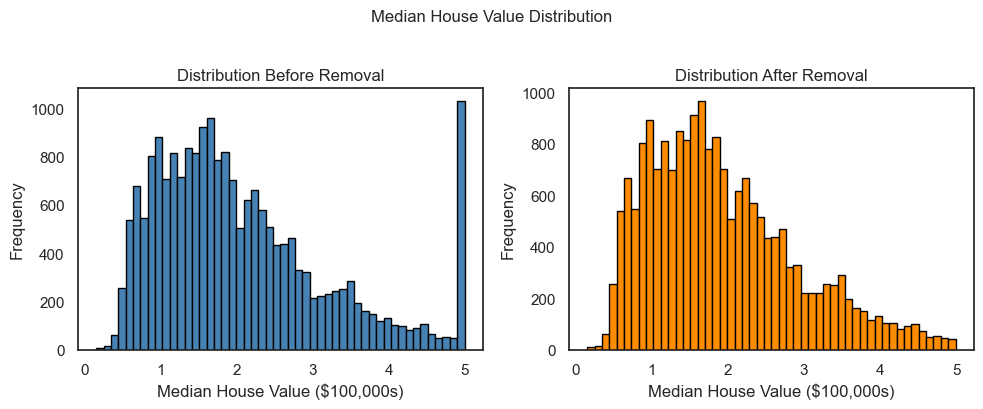

In [242]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_full = df.copy()
removed = (df_full["MedHouseVal"] == 5.0).sum()
print(f"Removed observations: {removed} ({removed/len(df_full)*100:.2f}%)")

df_trim = df_full[df_full["MedHouseVal"] < 5.0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

sns.scatterplot(
    x="MedInc", y="MedHouseVal", data=df_full,
    alpha=0.5, color="teal", ax=axes[0], edgecolor=None
)
axes[0].set_title("Before Removing Capped Values")
axes[0].set_xlabel("Median Income")
axes[0].set_ylabel("Median House Value ($100,000s)")

sns.scatterplot(
    x="MedInc", y="MedHouseVal", data=df_trim,
    alpha=0.5, color="darkorange", ax=axes[1], edgecolor=None
)
axes[1].set_title("After Removing Capped Values")
axes[1].set_xlabel("Median Income")
axes[1].set_ylabel("")

plt.suptitle("Effect of Top-Coding on Median House Value", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(df_full["MedHouseVal"], bins=50, color="steelblue", edgecolor="black")
axes[0].set_title("Distribution Before Removal")
axes[0].set_xlabel("Median House Value ($100,000s)")
axes[0].set_ylabel("Frequency")

axes[1].hist(df_trim["MedHouseVal"], bins=50, color="darkorange", edgecolor="black")
axes[1].set_title("Distribution After Removal")
axes[1].set_xlabel("Median House Value ($100,000s)")
axes[1].set_ylabel("Frequency")

plt.suptitle("Median House Value Distribution", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

### Exploring Target Transformations

One of the assumptions of OLS is that the model errors are normally distributed.  
When the target variable is heavily skewed, this assumption is often violated because the residuals inherit that skew.  
Transforming the target (for example with a log or square root) doesn’t change the underlying relationships but can make the residuals more symmetric and closer to normality.  
This step isn’t mandatory, but it can improve model stability and make inference from OLS more reliable.


                     Mean    Std  Skewness  Kurtosis
MedHouseVal         1.921  0.971     0.795     0.122
Log1p(MedHouseVal)  1.019  0.323     0.139    -0.654
Sqrt(MedHouseVal)   1.342  0.346     0.273    -0.517


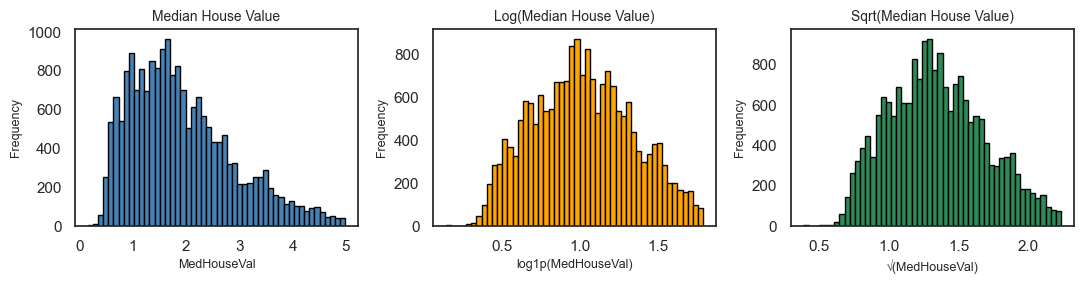

In [ ]:
df = df_trim.copy()
target = df["MedHouseVal"]

target_log = np.log1p(target)
target_sqrt = np.sqrt(target)

summary = pd.DataFrame({
    "Mean": [target.mean(), target_log.mean(), target_sqrt.mean()],
    "Std": [target.std(), target_log.std(), target_sqrt.std()],
    "Skewness": [target.skew(), target_log.skew(), target_sqrt.skew()],
    "Kurtosis": [target.kurtosis(), target_log.kurtosis(), target_sqrt.kurtosis()]
}, index=["MedHouseVal", "Log1p(MedHouseVal)", "Sqrt(MedHouseVal)"])

print(summary.round(3))

fig, axes = plt.subplots(1, 3, figsize=(11, 3))

axes[0].hist(target, bins=50, edgecolor="black", color="steelblue")
axes[0].set_title("Median House Value", fontsize=10)
axes[0].set_xlabel("MedHouseVal", fontsize=9)
axes[0].set_ylabel("Frequency", fontsize=9)

axes[1].hist(target_log, bins=50, edgecolor="black", color="orange")
axes[1].set_title("Log(Median House Value)", fontsize=10)
axes[1].set_xlabel("log1p(MedHouseVal)", fontsize=9)
axes[1].set_ylabel("Frequency", fontsize=9)

axes[2].hist(target_sqrt, bins=50, edgecolor="black", color="seagreen")
axes[2].set_title("Sqrt(Median House Value)", fontsize=10)
axes[2].set_xlabel("√(MedHouseVal)", fontsize=9)
axes[2].set_ylabel("Frequency", fontsize=9)

plt.tight_layout()
plt.show()

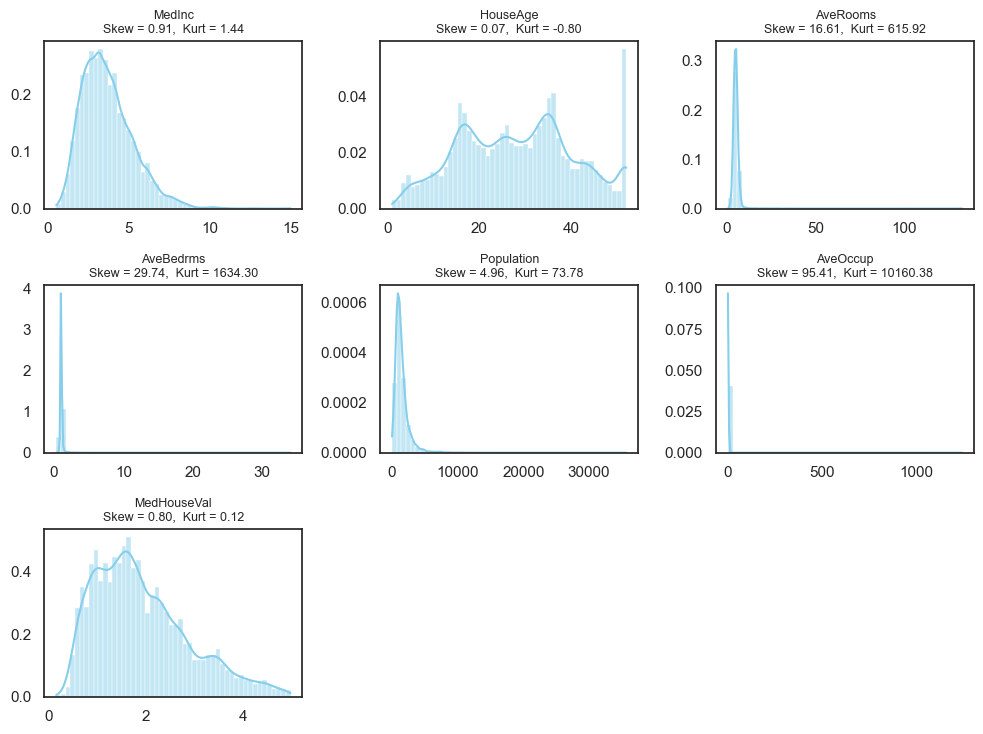

In [244]:
cols = [c for c in df.columns if c not in ["Latitude", "Longitude"]]

stats = pd.DataFrame({
    "skew": df[cols].skew(),
    "kurtosis": df[cols].kurtosis()
})

n_cols = 3
n_rows = int(np.ceil(len(cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 2.5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i], color="skyblue", stat="density")
    axes[i].set_title(
        f"{col}\nSkew = {stats.loc[col, 'skew']:.2f},  Kurt = {stats.loc[col, 'kurtosis']:.2f}",
        fontsize=9
    )
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Applying Log Transformations to Skewed Features

Several features, such as **median income**, **average rooms**, and **population**, are strongly right-skewed — most values are low, with a few extremely high ones.  
This imbalance can make linear regression less stable and weaken the linear relationship with the target.

To address this, I created a copy of the DataFrame and applied **logarithmic transformations** to these skewed variables.  
For `MedInc`, I used `np.log()` since it contains only positive values.  
For the others (`AveRooms`, `AveBedrms`, `AveOccup`, `Population`), I used `np.log1p()` to safely include zeros.  

These transformations compress large values, reduce skewness, and make the features behave more linearly with respect to the target, which improves model performance and interpretability.


In [225]:
df_transformed = df.copy()

df_transformed['MedInc'] = np.log(df['MedInc'])
df_transformed['AveRooms'] = np.log1p(df['AveRooms'])
df_transformed['AveBedrms'] = np.log1p(df['AveBedrms'])
df_transformed['AveOccup'] = np.log1p(df['AveOccup'])
df_transformed['Population'] = np.log1p(df['Population'])
df_transformed['MedHouseVal'] = np.log(df['MedHouseVal'])

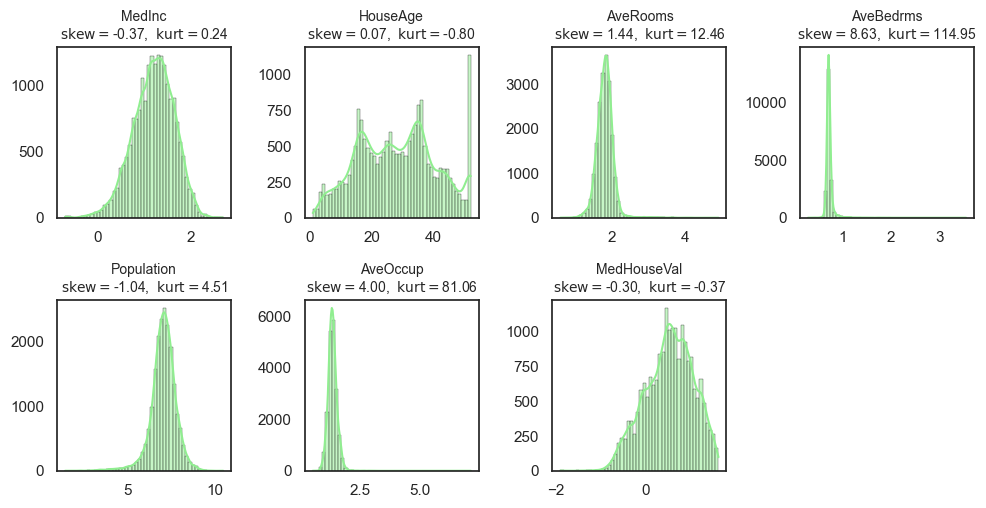

In [226]:
cols = [c for c in df_transformed.columns if c not in ["Latitude", "Longitude"]]

stats_trans = pd.DataFrame({
    'skew': df_transformed[cols].skew(),
    'kurtosis': df_transformed[cols].kurtosis()
})

n_rows_trans = 3  # or calculate dynamically: int(np.ceil(len(cols) / 4))
fig, axes = plt.subplots(n_rows_trans, 4, figsize=(10, 2.5 * n_rows_trans))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(df_transformed[col], bins=50, kde=True, ax=axes[i],
                 color='lightgreen', edgecolor='black')
    axes[i].set_title(
        f"{col}\n"
        r"$\text{skew} = $" + f"{stats_trans.loc[col, 'skew']:.2f},  "
        r"$\text{kurt} = $" + f"{stats_trans.loc[col, 'kurtosis']:.2f}",
        fontsize=10
    )
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


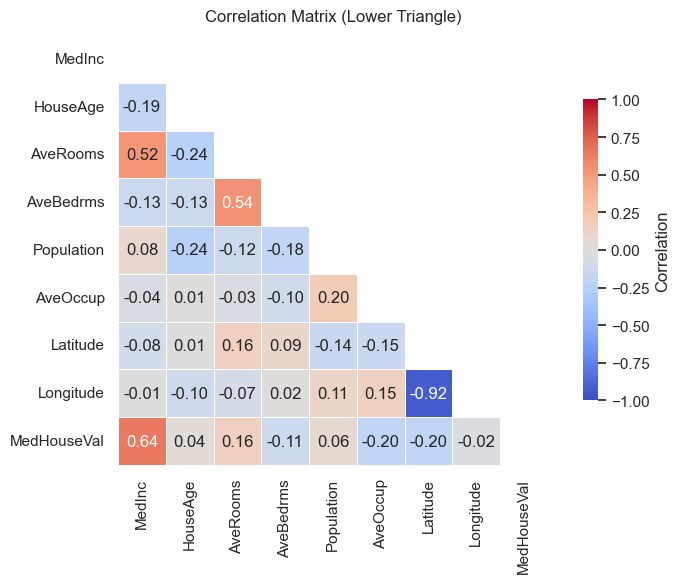

Highly correlated feature pairs (|r| > 0.8):


,Feature1,Feature2,Correlation
27,Longitude,Latitude,-0.924139



VARIANCE INFLATION FACTOR (VIF) ANALYSIS

VIF for Predictor Features:
VIF > 10 indicates high multicollinearity


,Feature,VIF
0,const,18704.472053
7,Latitude,9.933815
8,Longitude,9.388025
3,AveRooms,3.414518
1,MedInc,2.571077
4,AveBedrms,2.163381
2,HouseAge,1.255967
5,Population,1.196399
6,AveOccup,1.091100



Features with VIF > 10: 0
No severe multicollinearity detected (all VIF < 10)

VIF Interpretation Guide:
VIF = 1: No correlation
1 < VIF < 5: Moderate correlation
5 < VIF < 10: High correlation
VIF > 10: Severe multicollinearity


In [ ]:
corr = df_transformed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8, 6))
sns.set_theme(style="white")
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",     
    vmin=-1, vmax=1,
    center=0,
    square=True,
    linewidths=.4,
    cbar_kws={"shrink": .7, "label": "Correlation"}
)
plt.title("Correlation Matrix (Lower Triangle)", fontsize=12, pad=10)
plt.tight_layout()
plt.show()

threshold = 0.8
corr_pairs = (
    corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr = corr_pairs[abs(corr_pairs['Correlation']) > threshold]

print("Highly correlated feature pairs (|r| > 0.8):")
display(high_corr)

print("\n" + "="*60)
print("VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
print("="*60)

predictor_features = df_transformed.drop(columns=['MedHouseVal'])
features_with_constant = sm.add_constant(predictor_features)

vif_data = pd.DataFrame()
vif_data["Feature"] = features_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(features_with_constant.values, i) 
                   for i in range(features_with_constant.shape[1])]

print("\nVIF for Predictor Features:")
print("VIF > 10 indicates high multicollinearity")
display(vif_data.sort_values("VIF", ascending=False))

high_vif = vif_data[(vif_data["VIF"] > 10) & (vif_data["Feature"] != "const")]
print(f"\nFeatures with VIF > 10: {len(high_vif)}")
if len(high_vif) > 0:
    print("High multicollinearity detected in:")
    display(high_vif)
else:
    print("No severe multicollinearity detected (all VIF < 10)")

print("\nVIF Interpretation Guide:")
print("VIF = 1: No correlation")
print("1 < VIF < 5: Moderate correlation") 
print("5 < VIF < 10: High correlation")
print("VIF > 10: Severe multicollinearity")

### Evaluating the Impact of Geographic Features

Latitude and longitude often carry strong spatial information about housing prices in California, but they can also introduce collinearity or distort the model if they interact in nonlinear ways.  
To understand their individual contribution, I fit three OLS models:

1. One with both latitude and longitude  
2. One excluding longitude  
3. One excluding latitude  

I then compare their performance using **R²** and **RMSE**, and also examine the **Variance Inflation Factor (VIF)** to see how removing each geographic coordinate affects multicollinearity.  

This helps determine whether both coordinates are needed, or if one provides most of the spatial signal while the other mainly adds redundancy or noise.


In [ ]:

features_no_long = df_transformed.drop(columns=['MedHouseVal', 'Longitude'])
target_no_long = df_transformed['MedHouseVal']

features_train_no_long, features_test_no_long, target_train_no_long, target_test_no_long = train_test_split(
    features_no_long, target_no_long, test_size=0.2, random_state=1998
)

features_train_no_long_const = sm.add_constant(features_train_no_long)
features_test_no_long_const = sm.add_constant(features_test_no_long)

model_no_long = sm.OLS(target_train_no_long, features_train_no_long_const).fit()
predictions_no_long = model_no_long.predict(features_test_no_long_const)

testing_r2_no_long = r2_score(target_test_no_long, predictions_no_long)
testing_rmse_no_long = np.sqrt(mean_squared_error(target_test_no_long, predictions_no_long))


features_no_lat = df_transformed.drop(columns=['MedHouseVal', 'Latitude'])
target_no_lat = df_transformed['MedHouseVal']

features_train_no_lat, features_test_no_lat, target_train_no_lat, target_test_no_lat = train_test_split(
    features_no_lat, target_no_lat, test_size=0.2, random_state=1998
)

features_train_no_lat_const = sm.add_constant(features_train_no_lat)
features_test_no_lat_const = sm.add_constant(features_test_no_lat)

model_no_lat = sm.OLS(target_train_no_lat, features_train_no_lat_const).fit()
predictions_no_lat = model_no_lat.predict(features_test_no_lat_const)

testing_r2_no_lat = r2_score(target_test_no_lat, predictions_no_lat)
testing_rmse_no_lat = np.sqrt(mean_squared_error(target_test_no_lat, predictions_no_lat))

print("=== GEOGRAPHIC FEATURE COMPARISON ===")
print(f"Original (Both Lat/Long):  R² = {testing_r2:.3f}, RMSE = {testing_rmse:.3f}")
print(f"Latitude Only (No Long):    R² = {testing_r2_no_long:.3f}, RMSE = {testing_rmse_no_long:.3f}")

print("\n=== VIF COMPARISON ===")


features_no_long_vif = df_transformed.drop(columns=['MedHouseVal', 'Longitude'])
features_no_long_const = sm.add_constant(features_no_long_vif)
vif_no_long = pd.DataFrame()
vif_no_long["Feature"] = features_no_long_const.columns
vif_no_long["VIF"] = [variance_inflation_factor(features_no_long_const.values, i) 
                      for i in range(features_no_long_const.shape[1])]
print("VIF - Latitude Only:")
display(vif_no_long.sort_values("VIF", ascending=False))

features_no_lat_vif = df_transformed.drop(columns=['MedHouseVal', 'Latitude'])
features_no_lat_const = sm.add_constant(features_no_lat_vif)
vif_no_lat = pd.DataFrame()
vif_no_lat["Feature"] = features_no_lat_const.columns
vif_no_lat["VIF"] = [variance_inflation_factor(features_no_lat_const.values, i) 
                     for i in range(features_no_lat_const.shape[1])]
print("VIF - Longitude Only:")
display(vif_no_lat.sort_values("VIF", ascending=False))

best_model = max([
    (testing_r2, testing_rmse, "Both Lat/Long"),
    (testing_r2_no_long, testing_rmse_no_long, "Latitude Only"), 
    (testing_r2_no_lat, testing_rmse_no_lat, "Longitude Only")
], key=lambda x: x[0])

print(f"\n=== RECOMMENDATION ===")
print(f"Best performing: {best_model[2]} (R² = {best_model[0]:.3f}, RMSE = {best_model[1]:.3f})")

=== GEOGRAPHIC FEATURE COMPARISON ===
Original (Both Lat/Long):  R² = 0.635, RMSE = 0.320
Latitude Only (No Long):    R² = 0.534, RMSE = 0.362
Longitude Only (No Lat):    R² = 0.521, RMSE = 0.367

=== VIF COMPARISON ===
VIF - Latitude Only:


,Feature,VIF
0,const,613.136808
3,AveRooms,3.074091
1,MedInc,2.168043
4,AveBedrms,2.150719
5,Population,1.192306
2,HouseAge,1.166033
7,Latitude,1.121684
6,AveOccup,1.090038


VIF - Longitude Only:


,Feature,VIF
0,const,4163.001508
3,AveRooms,2.920832
4,AveBedrms,2.130959
1,MedInc,2.060887
5,Population,1.189047
2,HouseAge,1.177739
6,AveOccup,1.090581
7,Longitude,1.060056



=== RECOMMENDATION ===
Best performing: Both Lat/Long (R² = 0.635, RMSE = 0.320)


##### Keeping Both Coordinates

Latitude and longitude are correlated but both are needed for best performance.

**Results:**
- Both: R² = 0.635
- Only latitude: R² = 0.534  
- Only longitude: R² = 0.521

Keeping both gives significantly better results.

##### Baseline OLS

Starting model with log-transformed features. Our reference point for comparison.
- All 8 features + coordinates
- 80/20 split
- Fixed random seed

=== OLS Performance (seed=1998) ===
R² (train): 0.642
R² (test): 0.635
RMSE (test): 0.320
MAE (test): 0.241

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     3525.
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        18:08:44   Log-Likelihood:                -4324.9
No. Observations:               15718   AIC:                             8668.
Df Residuals:                   15709   BIC:                             8737.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

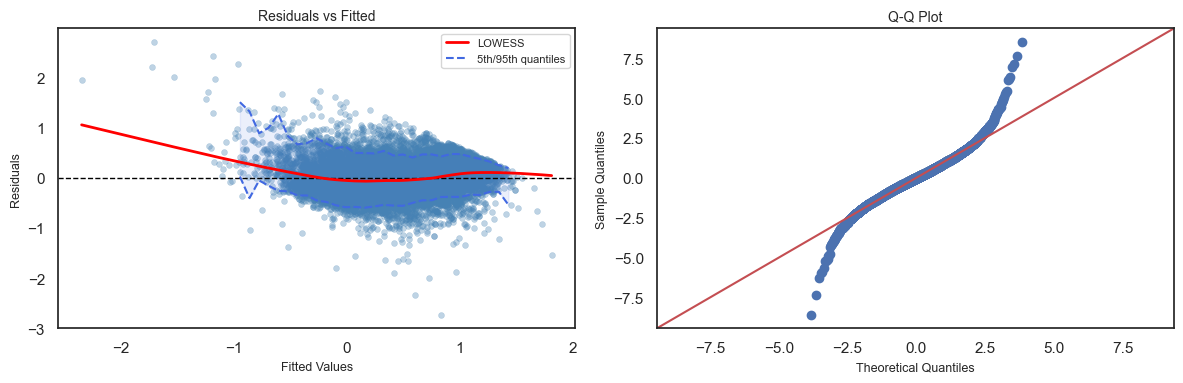

In [ ]:


features = df_transformed.drop(columns=['MedHouseVal'])
target = df_transformed['MedHouseVal']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=1998
)

features_train_with_intercept = sm.add_constant(features_train)
features_test_with_intercept = sm.add_constant(features_test)

regression_model = sm.OLS(target_train, features_train_with_intercept).fit()

predictions = regression_model.predict(features_test_with_intercept)

training_r2 = regression_model.rsquared
testing_r2 = r2_score(target_test, predictions)
testing_rmse = np.sqrt(mean_squared_error(target_test, predictions))
testing_mae = mean_absolute_error(target_test, predictions)

print("=== OLS Performance (seed=1998) ===")
print(f"R² (train): {training_r2:.3f}")
print(f"R² (test): {testing_r2:.3f}")
print(f"RMSE (test): {testing_rmse:.3f}")
print(f"MAE (test): {testing_mae:.3f}")

print("\n" + "="*80)
print(regression_model.summary())

fitted_values = regression_model.fittedvalues
model_residuals = regression_model.resid

lowess_smooth = sm.nonparametric.lowess(model_residuals, fitted_values, frac=0.3)

bin_edges = np.linspace(fitted_values.min(), fitted_values.max(), 50)
bin_indices = np.digitize(fitted_values, bin_edges)
quantile_05, quantile_95, bin_centers = [], [], []
for bin_index in range(1, len(bin_edges)):
    bin_mask = bin_indices == bin_index
    if bin_mask.sum() > 10:
        quantile_05.append(np.quantile(model_residuals[bin_mask], 0.05))
        quantile_95.append(np.quantile(model_residuals[bin_mask], 0.95))
        bin_centers.append((bin_edges[bin_index-1] + bin_edges[bin_index]) / 2)

figure, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(x=fitted_values, y=model_residuals, color='steelblue', alpha=0.35, edgecolor=None, s=18, ax=axes[0])
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0].plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', linewidth=2, label='LOWESS')
axes[0].plot(bin_centers, quantile_05, color='royalblue', linestyle='--', linewidth=1.5, label='5th/95th quantiles')
axes[0].plot(bin_centers, quantile_95, color='royalblue', linestyle='--', linewidth=1.5)
axes[0].fill_between(bin_centers, quantile_05, quantile_95, color='royalblue', alpha=0.10)
axes[0].set_title("Residuals vs Fitted", fontsize=10)
axes[0].set_xlabel("Fitted Values", fontsize=9)
axes[0].set_ylabel("Residuals", fontsize=9)
axes[0].legend(fontsize=8)

sm.qqplot(model_residuals, line='45', fit=True, ax=axes[1])
axes[1].set_title("Q-Q Plot", fontsize=10)
axes[1].set_xlabel("Theoretical Quantiles", fontsize=9)
axes[1].set_ylabel("Sample Quantiles", fontsize=9)

plt.tight_layout()
plt.show()

### Feature Engineering and Enhanced OLS Model

The baseline OLS model may not capture nonlinear relationships or variable interactions that influence housing prices.  
To address this, I create a set of engineered features that combine or transform existing predictors. These include interaction terms (e.g., income multiplied by rooms or age), ratios (bedrooms per room), and squared geographic coordinates to allow mild curvature effects.  

The idea is to give the linear model more expressive power while staying within the OLS framework.  
After fitting the enhanced model, I evaluate its performance using R², RMSE, and MAE, and examine the residuals and their distribution to check if the added terms improve model fit and reduce systematic bias.


Engineered features shape: (19648, 16)

=== Enhanced OLS Model Performance ===
R² (train): 0.668
R² (test): 0.662
RMSE (test): 0.308
MAE (test): 0.229


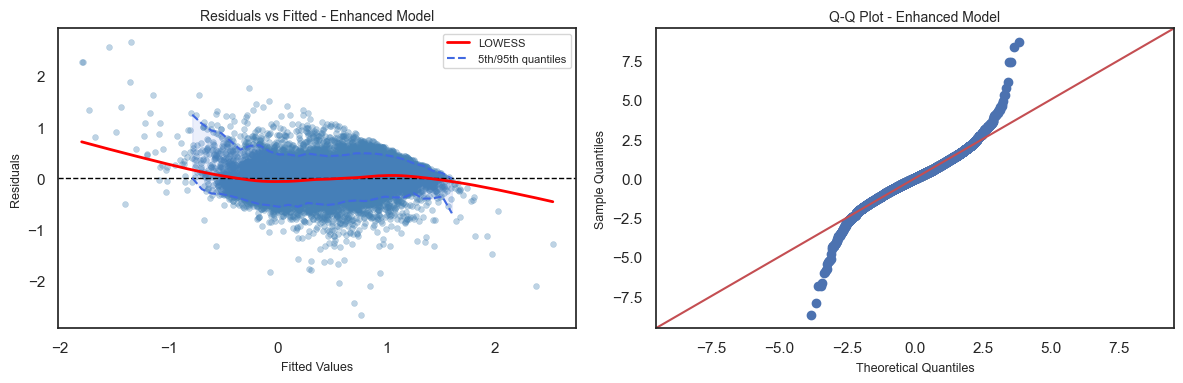

In [231]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

base_features = df_transformed.drop(columns=['MedHouseVal'])
target_variable = df_transformed['MedHouseVal']

engineered_features = base_features.copy()

engineered_features["Income_RoomInteraction"] = base_features["MedInc"] * base_features["AveRooms"]
engineered_features["Income_AgeInteraction"] = base_features["MedInc"] * base_features["HouseAge"]
engineered_features["BedroomRatio"] = base_features["AveBedrms"] / base_features["AveRooms"]
engineered_features["Population_Occupancy"] = base_features["Population"] * base_features["AveOccup"]
engineered_features["Latitude_Income"] = base_features["Latitude"] * base_features["MedInc"]
engineered_features["Longitude_Income"] = base_features["Longitude"] * base_features["MedInc"]
engineered_features["LatitudeSquared"] = base_features["Latitude"] ** 2
engineered_features["LongitudeSquared"] = base_features["Longitude"] ** 2

print("Engineered features shape:", engineered_features.shape)

features_train_set, features_test_set, target_train_set, target_test_set = train_test_split(
    engineered_features, target_variable, test_size=0.2, random_state=1998
)

train_with_intercept = sm.add_constant(features_train_set)
test_with_intercept = sm.add_constant(features_test_set)

enhanced_model = sm.OLS(target_train_set, train_with_intercept).fit()
enhanced_predictions = enhanced_model.predict(test_with_intercept)

training_r2_enhanced = enhanced_model.rsquared
testing_r2_enhanced = r2_score(target_test_set, enhanced_predictions)
testing_rmse_enhanced = np.sqrt(mean_squared_error(target_test_set, enhanced_predictions))
testing_mae_enhanced = mean_absolute_error(target_test_set, enhanced_predictions)

print("\n=== Enhanced OLS Model Performance ===")
print(f"R² (train): {training_r2_enhanced:.3f}")
print(f"R² (test): {testing_r2_enhanced:.3f}")
print(f"RMSE (test): {testing_rmse_enhanced:.3f}")
print(f"MAE (test): {testing_mae_enhanced:.3f}")

fitted_values_enhanced = enhanced_model.fittedvalues
residuals_enhanced = enhanced_model.resid
lowess_smooth_enhanced = sm.nonparametric.lowess(residuals_enhanced, fitted_values_enhanced, frac=0.3)

residual_bins = np.linspace(fitted_values_enhanced.min(), fitted_values_enhanced.max(), 50)
bin_assignments = np.digitize(fitted_values_enhanced, residual_bins)
lower_quantile, upper_quantile, bin_midpoints = [], [], []
for bin_index in range(1, len(residual_bins)):
    bin_mask = bin_assignments == bin_index
    if bin_mask.sum() > 10:
        lower_quantile.append(np.quantile(residuals_enhanced[bin_mask], 0.05))
        upper_quantile.append(np.quantile(residuals_enhanced[bin_mask], 0.95))
        bin_midpoints.append((residual_bins[bin_index-1] + residual_bins[bin_index]) / 2)

diagnostic_figure, diagnostic_axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(x=fitted_values_enhanced, y=residuals_enhanced, color='steelblue', alpha=0.35, edgecolor=None, s=18, ax=diagnostic_axes[0])
diagnostic_axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
diagnostic_axes[0].plot(lowess_smooth_enhanced[:, 0], lowess_smooth_enhanced[:, 1], color='red', linewidth=2, label='LOWESS')
diagnostic_axes[0].plot(bin_midpoints, lower_quantile, color='royalblue', linestyle='--', linewidth=1.5, label='5th/95th quantiles')
diagnostic_axes[0].plot(bin_midpoints, upper_quantile, color='royalblue', linestyle='--', linewidth=1.5)
diagnostic_axes[0].fill_between(bin_midpoints, lower_quantile, upper_quantile, color='royalblue', alpha=0.10)
diagnostic_axes[0].set_title("Residuals vs Fitted - Enhanced Model", fontsize=10)
diagnostic_axes[0].set_xlabel("Fitted Values", fontsize=9)
diagnostic_axes[0].set_ylabel("Residuals", fontsize=9)
diagnostic_axes[0].legend(fontsize=8)

sm.qqplot(residuals_enhanced, line='45', fit=True, ax=diagnostic_axes[1])
diagnostic_axes[1].set_title("Q-Q Plot - Enhanced Model", fontsize=10)
diagnostic_axes[1].set_xlabel("Theoretical Quantiles", fontsize=9)
diagnostic_axes[1].set_ylabel("Sample Quantiles", fontsize=9)

plt.tight_layout()
plt.show()

### Polynomial Feature Expansion and OLS Model

To capture nonlinear relationships between predictors and housing prices while staying in the OLS framework, I expand the original features using polynomial terms of degree two.  
This adds squared terms and pairwise interactions between variables, allowing the linear model to approximate curved patterns in the data.

After generating the polynomial feature set, I fit an OLS model and evaluate its performance on a test split using R², RMSE, and MAE.  
Residual and Q–Q plots are used to check whether the model fit improves or if the added complexity mostly increases variance.  
This step tests how far a linear model can go in explaining nonlinear structure before overfitting becomes noticeable.


Polynomial feature space dimensions: (19648, 44)

=== Polynomial Regression Performance ===
R² (train): 0.713
R² (test): 0.707
RMSE (test): 0.287
MAE (test): 0.214


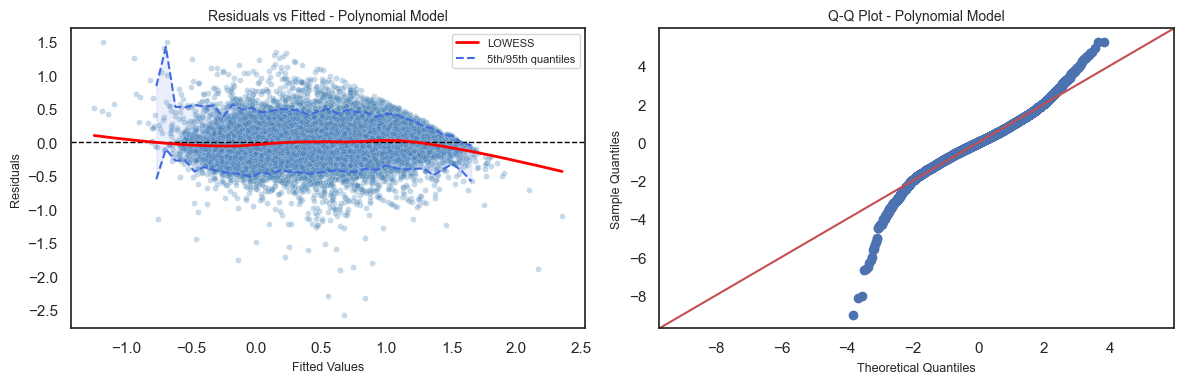

In [ ]:


base_predictors = df_transformed.drop(columns=['MedHouseVal'])
target_response = df_transformed['MedHouseVal']

polynomial_transformer = PolynomialFeatures(degree=2, include_bias=False)
polynomial_features = polynomial_transformer.fit_transform(base_predictors)
polynomial_feature_names = polynomial_transformer.get_feature_names_out(base_predictors.columns)
polynomial_dataframe = pd.DataFrame(polynomial_features, columns=polynomial_feature_names, index=base_predictors.index)

print("Polynomial feature space dimensions:", polynomial_dataframe.shape)
training_features_poly, testing_features_poly, training_target_poly, testing_target_poly = train_test_split(
    polynomial_dataframe, target_response, test_size=0.2, random_state=1998
)

training_with_constant_poly = sm.add_constant(training_features_poly)
testing_with_constant_poly = sm.add_constant(testing_features_poly)

polynomial_model = sm.OLS(training_target_poly, training_with_constant_poly).fit()
polynomial_predictions = polynomial_model.predict(testing_with_constant_poly)

training_r2_polynomial = polynomial_model.rsquared
testing_r2_polynomial = r2_score(testing_target_poly, polynomial_predictions)
testing_rmse_polynomial = np.sqrt(mean_squared_error(testing_target_poly, polynomial_predictions))
testing_mae_polynomial = mean_absolute_error(testing_target_poly, polynomial_predictions)

print("\n=== Polynomial Regression Performance ===")
print(f"R² (train): {training_r2_polynomial:.3f}")
print(f"R² (test): {testing_r2_polynomial:.3f}")
print(f"RMSE (test): {testing_rmse_polynomial:.3f}")
print(f"MAE (test): {testing_mae_polynomial:.3f}")

fitted_values_polynomial = polynomial_model.fittedvalues
residuals_polynomial = polynomial_model.resid

lowess_smooth_polynomial = sm.nonparametric.lowess(residuals_polynomial, fitted_values_polynomial, frac=0.3)

residual_bins_polynomial = np.linspace(fitted_values_polynomial.min(), fitted_values_polynomial.max(), 50)
bin_assignments_polynomial = np.digitize(fitted_values_polynomial, residual_bins_polynomial)
lower_quantile_polynomial, upper_quantile_polynomial, bin_centers_polynomial = [], [], []
for bin_index in range(1, len(residual_bins_polynomial)):
    bin_mask_polynomial = bin_assignments_polynomial == bin_index
    if bin_mask_polynomial.sum() > 10:
        lower_quantile_polynomial.append(np.quantile(residuals_polynomial[bin_mask_polynomial], 0.05))
        upper_quantile_polynomial.append(np.quantile(residuals_polynomial[bin_mask_polynomial], 0.95))
        bin_centers_polynomial.append((residual_bins_polynomial[bin_index-1] + residual_bins_polynomial[bin_index]) / 2)

diagnostic_figure_poly, diagnostic_axes_poly = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(x=fitted_values_polynomial, y=residuals_polynomial, color="steelblue", alpha=0.3, s=18, ax=diagnostic_axes_poly[0])
diagnostic_axes_poly[0].axhline(0, color="black", linestyle="--", linewidth=1)
diagnostic_axes_poly[0].plot(lowess_smooth_polynomial[:, 0], lowess_smooth_polynomial[:, 1], color="red", linewidth=2, label="LOWESS")
diagnostic_axes_poly[0].plot(bin_centers_polynomial, lower_quantile_polynomial, color="royalblue", linestyle="--", linewidth=1.5, label="5th/95th quantiles")
diagnostic_axes_poly[0].plot(bin_centers_polynomial, upper_quantile_polynomial, color="royalblue", linestyle="--", linewidth=1.5)
diagnostic_axes_poly[0].fill_between(bin_centers_polynomial, lower_quantile_polynomial, upper_quantile_polynomial, color="royalblue", alpha=0.10)
diagnostic_axes_poly[0].set_title("Residuals vs Fitted - Polynomial Model", fontsize=10)
diagnostic_axes_poly[0].set_xlabel("Fitted Values", fontsize=9)
diagnostic_axes_poly[0].set_ylabel("Residuals", fontsize=9)
diagnostic_axes_poly[0].legend(fontsize=8)

sm.qqplot(residuals_polynomial, line="45", fit=True, ax=diagnostic_axes_poly[1])
diagnostic_axes_poly[1].set_title("Q-Q Plot - Polynomial Model", fontsize=10)
diagnostic_axes_poly[1].set_xlabel("Theoretical Quantiles", fontsize=9)
diagnostic_axes_poly[1].set_ylabel("Sample Quantiles", fontsize=9)

plt.tight_layout()
plt.show()

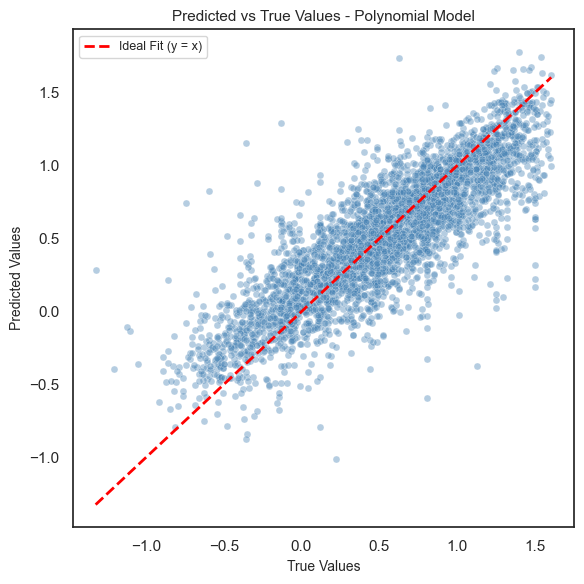

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=testing_target_poly, y=polynomial_predictions, color="steelblue", alpha=0.4, s=25)
plt.plot(
    [testing_target_poly.min(), testing_target_poly.max()],
    [testing_target_poly.min(), testing_target_poly.max()],
    color="red", linestyle="--", linewidth=2, label="Ideal Fit (y = x)"
)
plt.xlabel("True Values", fontsize=10)
plt.ylabel("Predicted Values", fontsize=10)
plt.title("Predicted vs True Values - Polynomial Model", fontsize=11)
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()
